# Experiment Materials Generator (Reference Image Workflow)

This notebook generates 60+ distinct images for a linguistic experiment: 3 Entities (Wizard, Pirate, Chef) x 20 Transitive Actions.

**New Feature: Reference Image Consistency**
To ensure the character looks the same across all actions:
1.  **Generate Base Images**: First, we generate a "Reference" image for each character (standing still).
2.  **Iterate**: We use that reference image as an input to the model for every action (Image-to-Image editing), ensuring the clothes, face, and style remain consistent.

In [1]:
# @title 1. Setup & Installation
%pip install -U -q "google-genai>=1.40.0" pillow requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.


In [8]:
# @title 2. Configuration
import os
from google.colab import userdata
from google import genai
from IPython.display import display
from PIL import Image as PILImage
import io
import requests

# @markdown **Settings:**
PROVIDER = "Gemini" # @param ["Gemini"]
MODEL_ID = "gemini-2.5-flash-image" # @param ["gemini-2.5-flash-image", "gemini-3-pro-image-preview"]
NUM_RUNS = 5 # @param {type:"integer"}
USE_REFERENCE_IMAGE = True # @param {type:"boolean"}

# --------------------------------------------------------------------------
# SECURE SETUP (Secrets)
# --------------------------------------------------------------------------
gemini_client = None
if PROVIDER == "Gemini":
    try:
        GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
        gemini_client = genai.Client(api_key=GOOGLE_API_KEY)
        print(f"✅ Gemini Client Ready. Model: {MODEL_ID}")
    except Exception as e:
        print("⚠️ GOOGLE_API_KEY secret not found. Please add it to Secrets.")
        GOOGLE_API_KEY = input("Or paste Google API Key here: ")
        gemini_client = genai.Client(api_key=GOOGLE_API_KEY)

# Create output directory
os.makedirs("materials", exist_ok=True)
os.makedirs("materials/base", exist_ok=True)

✅ Gemini Client Ready. Model: gemini-2.5-flash-image


In [13]:
# @title 3. Define Characters & Actions

STYLE_PROMPT = "A clean black and white cartoon line drawing with bold, even black outlines, in the style of a coloring page, the style does not have to attire to children necessarily. No shading, no gray, just black lines on white background. Minimalist details."

CHARACTERS = {
    "Wizard": "A friendly wizard character wearing a starry robe and a pointed hat with a long beard.",
    "Pirate": "A generic pirate character with an eye patch, a bandana, and a striped shirt.",
    "Chef": "A generic chef character wearing a tall white chef's hat and a double-breasted jacket."
}

ACTIONS = {
    # Irregular Verbs
    "cut_bread": "cutting a loaf of bread with a knife on a cutting board",
    "build_tower": "stacking wooden blocks to build a tall tower",
    "sweep_floor": "sweeping the floor with a traditional broom",
    "ride_bicycle": "riding a simple bicycle",
    "drink_coffee": "drinking from a steaming mug",
    "throw_frisbee": "throwing a frisbee disc",
    "break_stick": "snapping a wooden stick in half with both hands",
    "eat_apple": "eating a shiny apple, holding it to their mouth",
    "dig_hole": "digging a hole in the ground with a shovel",
    "light_candle": "lighting a candle with a matchstick",

    # Regular Verbs
    "paint_canvas": "painting on an art canvas on an easel with a brush",
    "kick_ball": "kicking a soccer ball",
    "play_guitar": "playing an acoustic guitar",
    "wash_dish": "washing a plate with a soapy sponge",
    "stir_pot": "stirring a cooking pot with a ladle",
    "climb_ladder": "climbing up a simple wooden ladder",
    "push_cart": "pushing a shopping cart forward",
    "peel_banana": "peeling a banana",
    "smell_flower": "smelling a flower held in their hand",
    "hammer_nail": "hammering a nail into a piece of wood"
}

--- Checking Base Images ---
🎨 Generating NEW base for Wizard...
Saved materials/base/wizard_base.png


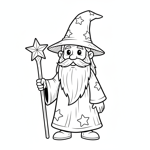

🎨 Generating NEW base for Pirate...
Saved materials/base/pirate_base.png


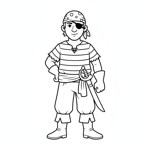

🎨 Generating NEW base for Chef...
Saved materials/base/chef_base.png


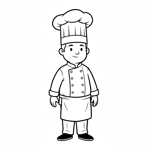

In [14]:
# @title 4. Generate/Load Base Images (Crucial for Consistency)
# @markdown Run this cell to generate the 'Reference' images for each character.
# @markdown If you don't like a reference, delete it from `materials/base` and run this again.

def generate_gemini(prompt, input_image=None):
    try:
        contents = [prompt]
        if input_image:
            contents.append(input_image)

        response = gemini_client.models.generate_content(
            model=MODEL_ID,
            contents=contents,
            config=genai.types.GenerateContentConfig(
                response_modalities=['Image']
            )
        )
        for part in response.parts:
            if image := part.as_image():
                 # The SDK's image object only supports .save(path), not format args.
                 # Save to a temp file, then load as PIL.
                 temp_path = "/tmp/gemini_temp.png"
                 image.save(temp_path)
                 return PILImage.open(temp_path)
    except Exception as e:
        print(f"Gemini Error: {e}")
    return None

BASE_IMAGES = {}

print("--- Checking Base Images ---")
for entity_name, entity_desc in CHARACTERS.items():
    filename = f"materials/base/{entity_name.lower()}_base.png"

    if os.path.exists(filename):
        print(f"✅ Found existing base for {entity_name}")
        BASE_IMAGES[entity_name] = PILImage.open(filename)
        # display(BASE_IMAGES[entity_name].resize((100, 100)))
    else:
        print(f"🎨 Generating NEW base for {entity_name}...")
        # Prompt for base: Neutral stance
        base_prompt = (f"{STYLE_PROMPT} {entity_desc} Full body shot. "
                       f"Standing in a neutral pose. Isolated on white background.")

        img = generate_gemini(base_prompt)
        if img:
            img.save(filename)
            BASE_IMAGES[entity_name] = img
            print(f"Saved {filename}")
            display(img.resize((150, 150)))
        else:
            print(f"❌ Failed to generate base for {entity_name}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Starting generation... Total images: 300
(1/300) Wizard - cut_bread_v1... Done.


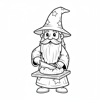

(2/300) Wizard - cut_bread_v2... Done.
(3/300) Wizard - cut_bread_v3... Done.
(4/300) Wizard - cut_bread_v4... Done.
(5/300) Wizard - cut_bread_v5... Done.
(6/300) Wizard - build_tower_v1... Done.


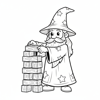

(7/300) Wizard - build_tower_v2... Done.
(8/300) Wizard - build_tower_v3... Done.
(9/300) Wizard - build_tower_v4... Done.
(10/300) Wizard - build_tower_v5... Done.
(11/300) Wizard - sweep_floor_v1... Done.


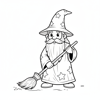

(12/300) Wizard - sweep_floor_v2... Done.
(13/300) Wizard - sweep_floor_v3... Done.
(14/300) Wizard - sweep_floor_v4... Done.
(15/300) Wizard - sweep_floor_v5... Done.
(16/300) Wizard - ride_bicycle_v1... Done.


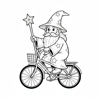

(17/300) Wizard - ride_bicycle_v2... Done.
(18/300) Wizard - ride_bicycle_v3... Done.
(19/300) Wizard - ride_bicycle_v4... Done.
(20/300) Wizard - ride_bicycle_v5... Done.
(21/300) Wizard - drink_coffee_v1... Done.


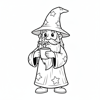

(22/300) Wizard - drink_coffee_v2... Done.
(23/300) Wizard - drink_coffee_v3... Done.
(24/300) Wizard - drink_coffee_v4... Done.
(25/300) Wizard - drink_coffee_v5... Done.
(26/300) Wizard - throw_frisbee_v1... Done.


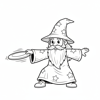

(27/300) Wizard - throw_frisbee_v2... Done.
(28/300) Wizard - throw_frisbee_v3... Done.
(29/300) Wizard - throw_frisbee_v4... Done.
(30/300) Wizard - throw_frisbee_v5... Done.
(31/300) Wizard - break_stick_v1... Done.


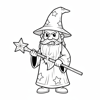

(32/300) Wizard - break_stick_v2... Done.
(33/300) Wizard - break_stick_v3... Done.
(34/300) Wizard - break_stick_v4... Done.
(35/300) Wizard - break_stick_v5... Done.
(36/300) Wizard - eat_apple_v1... Done.


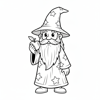

(37/300) Wizard - eat_apple_v2... Done.
(38/300) Wizard - eat_apple_v3... Done.
(39/300) Wizard - eat_apple_v4... Done.
(40/300) Wizard - eat_apple_v5... Done.
(41/300) Wizard - dig_hole_v1... Done.


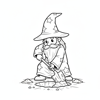

(42/300) Wizard - dig_hole_v2... Done.
(43/300) Wizard - dig_hole_v3... Done.
(44/300) Wizard - dig_hole_v4... Done.
(45/300) Wizard - dig_hole_v5... Done.
(46/300) Wizard - light_candle_v1... Done.


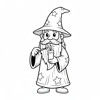

(47/300) Wizard - light_candle_v2... Done.
(48/300) Wizard - light_candle_v3... Done.
(49/300) Wizard - light_candle_v4... Done.
(50/300) Wizard - light_candle_v5... Done.
(51/300) Wizard - paint_canvas_v1... Done.


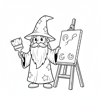

(52/300) Wizard - paint_canvas_v2... Done.
(53/300) Wizard - paint_canvas_v3... Done.
(54/300) Wizard - paint_canvas_v4... Done.
(55/300) Wizard - paint_canvas_v5... Done.
(56/300) Wizard - kick_ball_v1... Done.


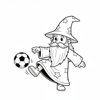

(57/300) Wizard - kick_ball_v2... Done.
(58/300) Wizard - kick_ball_v3... Done.
(59/300) Wizard - kick_ball_v4... Done.
(60/300) Wizard - kick_ball_v5... Done.
(61/300) Wizard - play_guitar_v1... Done.


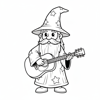

(62/300) Wizard - play_guitar_v2... Done.
(63/300) Wizard - play_guitar_v3... Done.
(64/300) Wizard - play_guitar_v4... Done.
(65/300) Wizard - play_guitar_v5... Done.
(66/300) Wizard - wash_dish_v1... Done.


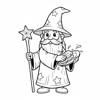

(67/300) Wizard - wash_dish_v2... Done.
(68/300) Wizard - wash_dish_v3... Done.
(69/300) Wizard - wash_dish_v4... Done.
(70/300) Wizard - wash_dish_v5... Done.
(71/300) Wizard - stir_pot_v1... Done.


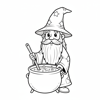

(72/300) Wizard - stir_pot_v2... Done.
(73/300) Wizard - stir_pot_v3... Done.
(74/300) Wizard - stir_pot_v4... Done.
(75/300) Wizard - stir_pot_v5... Done.
(76/300) Wizard - climb_ladder_v1... Done.


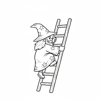

(77/300) Wizard - climb_ladder_v2... Done.
(78/300) Wizard - climb_ladder_v3... Done.
(79/300) Wizard - climb_ladder_v4... Done.
(80/300) Wizard - climb_ladder_v5... Done.
(81/300) Wizard - push_cart_v1... Done.


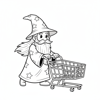

(82/300) Wizard - push_cart_v2... Done.
(83/300) Wizard - push_cart_v3... Done.
(84/300) Wizard - push_cart_v4... Done.
(85/300) Wizard - push_cart_v5... Done.
(86/300) Wizard - peel_banana_v1... Done.


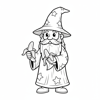

(87/300) Wizard - peel_banana_v2... Done.
(88/300) Wizard - peel_banana_v3... Done.
(89/300) Wizard - peel_banana_v4... Done.
(90/300) Wizard - peel_banana_v5... Done.
(91/300) Wizard - smell_flower_v1... Done.


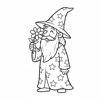

(92/300) Wizard - smell_flower_v2... Done.
(93/300) Wizard - smell_flower_v3... Done.
(94/300) Wizard - smell_flower_v4... Done.
(95/300) Wizard - smell_flower_v5... Done.
(96/300) Wizard - hammer_nail_v1... Done.


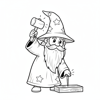

(97/300) Wizard - hammer_nail_v2... Done.
(98/300) Wizard - hammer_nail_v3... Done.
(99/300) Wizard - hammer_nail_v4... Done.
(100/300) Wizard - hammer_nail_v5... Done.
(101/300) Pirate - cut_bread_v1... Done.


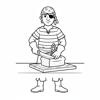

(102/300) Pirate - cut_bread_v2... Done.
(103/300) Pirate - cut_bread_v3... Done.
(104/300) Pirate - cut_bread_v4... Done.
(105/300) Pirate - cut_bread_v5... Done.
(106/300) Pirate - build_tower_v1... Done.


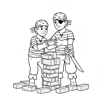

(107/300) Pirate - build_tower_v2... Done.
(108/300) Pirate - build_tower_v3... Done.
(109/300) Pirate - build_tower_v4... Done.
(110/300) Pirate - build_tower_v5... Done.
(111/300) Pirate - sweep_floor_v1... Done.


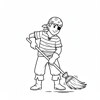

(112/300) Pirate - sweep_floor_v2... Done.
(113/300) Pirate - sweep_floor_v3... Done.
(114/300) Pirate - sweep_floor_v4... Done.
(115/300) Pirate - sweep_floor_v5... Done.
(116/300) Pirate - ride_bicycle_v1... Done.


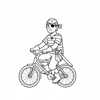

(117/300) Pirate - ride_bicycle_v2... Done.
(118/300) Pirate - ride_bicycle_v3... Done.
(119/300) Pirate - ride_bicycle_v4... Done.
(120/300) Pirate - ride_bicycle_v5... Done.
(121/300) Pirate - drink_coffee_v1... Done.


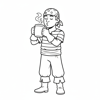

(122/300) Pirate - drink_coffee_v2... Done.
(123/300) Pirate - drink_coffee_v3... Done.
(124/300) Pirate - drink_coffee_v4... Done.
(125/300) Pirate - drink_coffee_v5... Done.
(126/300) Pirate - throw_frisbee_v1... Done.


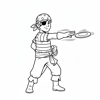

(127/300) Pirate - throw_frisbee_v2... Done.
(128/300) Pirate - throw_frisbee_v3... Done.
(129/300) Pirate - throw_frisbee_v4... Done.
(130/300) Pirate - throw_frisbee_v5... Done.
(131/300) Pirate - break_stick_v1... Done.


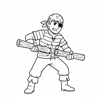

(132/300) Pirate - break_stick_v2... Done.
(133/300) Pirate - break_stick_v3... Done.
(134/300) Pirate - break_stick_v4... Done.
(135/300) Pirate - break_stick_v5... Done.
(136/300) Pirate - eat_apple_v1... Done.


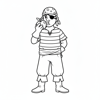

(137/300) Pirate - eat_apple_v2... Done.
(138/300) Pirate - eat_apple_v3... Done.
(139/300) Pirate - eat_apple_v4... Done.
(140/300) Pirate - eat_apple_v5... Done.
(141/300) Pirate - dig_hole_v1... Done.


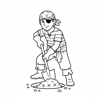

(142/300) Pirate - dig_hole_v2... Done.
(143/300) Pirate - dig_hole_v3... Done.
(144/300) Pirate - dig_hole_v4... Done.
(145/300) Pirate - dig_hole_v5... Done.
(146/300) Pirate - light_candle_v1... Done.


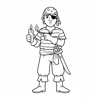

(147/300) Pirate - light_candle_v2... Done.
(148/300) Pirate - light_candle_v3... Done.
(149/300) Pirate - light_candle_v4... Done.
(150/300) Pirate - light_candle_v5... Done.
(151/300) Pirate - paint_canvas_v1... Done.


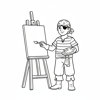

(152/300) Pirate - paint_canvas_v2... Done.
(153/300) Pirate - paint_canvas_v3... Done.
(154/300) Pirate - paint_canvas_v4... Done.
(155/300) Pirate - paint_canvas_v5... Done.
(156/300) Pirate - kick_ball_v1... Done.


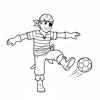

(157/300) Pirate - kick_ball_v2... Done.
(158/300) Pirate - kick_ball_v3... Done.
(159/300) Pirate - kick_ball_v4... Done.
(160/300) Pirate - kick_ball_v5... Done.
(161/300) Pirate - play_guitar_v1... Done.


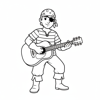

(162/300) Pirate - play_guitar_v2... Done.
(163/300) Pirate - play_guitar_v3... Done.
(164/300) Pirate - play_guitar_v4... Done.
(165/300) Pirate - play_guitar_v5... Done.
(166/300) Pirate - wash_dish_v1... Done.


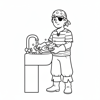

(167/300) Pirate - wash_dish_v2... Done.
(168/300) Pirate - wash_dish_v3... Done.
(169/300) Pirate - wash_dish_v4... Done.
(170/300) Pirate - wash_dish_v5... Done.
(171/300) Pirate - stir_pot_v1... Done.


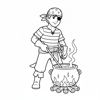

(172/300) Pirate - stir_pot_v2... Done.
(173/300) Pirate - stir_pot_v3... Done.
(174/300) Pirate - stir_pot_v4... Done.
(175/300) Pirate - stir_pot_v5... Done.
(176/300) Pirate - climb_ladder_v1... Done.


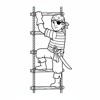

(177/300) Pirate - climb_ladder_v2... Done.
(178/300) Pirate - climb_ladder_v3... Done.
(179/300) Pirate - climb_ladder_v4... Done.
(180/300) Pirate - climb_ladder_v5... Done.
(181/300) Pirate - push_cart_v1... Done.


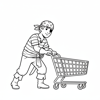

(182/300) Pirate - push_cart_v2... Done.
(183/300) Pirate - push_cart_v3... Done.
(184/300) Pirate - push_cart_v4... Done.
(185/300) Pirate - push_cart_v5... Done.
(186/300) Pirate - peel_banana_v1... Done.


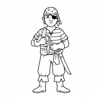

(187/300) Pirate - peel_banana_v2... Done.
(188/300) Pirate - peel_banana_v3... Done.
(189/300) Pirate - peel_banana_v4... Done.
(190/300) Pirate - peel_banana_v5... Done.
(191/300) Pirate - smell_flower_v1... 

In [ ]:
# @title 5. Generate Actions (Using Reference)
import time
total = len(CHARACTERS) * len(ACTIONS) * NUM_RUNS
count = 0

print(f"Starting generation... Total images: {total}")

for entity_name, entity_desc in CHARACTERS.items():
    # Get the reference image for this character
    ref_image = BASE_IMAGES.get(entity_name) if USE_REFERENCE_IMAGE else None

    if USE_REFERENCE_IMAGE and not ref_image:
        print(f"⚠️ Warning: No base image for {entity_name}. Generating from scratch.")

    for action_key, action_desc in ACTIONS.items():

        # Strategy: When using reference, we ask to *modify* or *depict* the character doing the action
        # The prompt needs to be strong enough to override the "neutral pose" of the reference
        full_prompt = (f"{STYLE_PROMPT} {entity_desc} The character is {action_desc}. "
                       f"Full body shot. Clear action. Isolated on white background.")

        for i in range(NUM_RUNS):
            run_suffix = f"_v{i+1}" if NUM_RUNS > 1 else ""
            print(f"({count+1}/{total}) {entity_name} - {action_key}{run_suffix}...", end=" ")

            # Generate with Reference Image if available
            image = generate_gemini(full_prompt, input_image=ref_image)

            if image:
                filename = f"materials/{entity_name.lower()}_{action_key}{run_suffix}.png"
                image.save(filename)
                print("Done.")
                if i == 0:
                    display(image.resize((100, 100)))
            else:
                print("Failed.")

            count += 1
            time.sleep(1.5) # Slight delay for robustness

print("Generation Complete!")

In [ ]:
# @title 6. Download Results
!zip -r experiment_materials.zip materials
from google.colab import files
files.download('experiment_materials.zip')

updating: materials/ (stored 0%)
updating: materials/pirate_throw_frisbee_v1.png (deflated 0%)
updating: materials/wizard_eat_apple_v1.png (deflated 0%)
updating: materials/chef_eat_apple_v2.png (deflated 0%)
updating: materials/pirate_hammer_nail_v2.png (deflated 0%)
updating: materials/pirate_ride_bicycle_v2.png (deflated 0%)
updating: materials/wizard_peel_banana_v2.png (deflated 0%)
updating: materials/chef_push_cart_v1.png (deflated 0%)
updating: materials/pirate_paint_canvas_v1.png (deflated 0%)
updating: materials/pirate_build_tower_v2.png (deflated 0%)
updating: materials/wizard_push_cart_v2.png (deflated 0%)
updating: materials/chef_eat_apple_v1.png (deflated 0%)
updating: materials/pirate_light_candle_v2.png (deflated 0%)
updating: materials/pirate_climb_ladder_v1.png (deflated 0%)
updating: materials/chef_peel_banana_v1.png (deflated 0%)
updating: materials/chef_drink_coffee_v2.png (deflated 0%)
updating: materials/chef_cut_bread_v1.png (deflated 0%)
updating: materials/pira

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>